# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import svm
import re
from bs4 import BeautifulSoup
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [14]:
#Sampling 100K points  for linear kernel
final_lin=final.groupby('Score').apply(lambda x: x.sample(50000))#sampling equal number of points from each class
final_lin['Score'].value_counts()

1    50000
0    50000
Name: Score, dtype: int64

In [10]:
#Sampling 20K points for rbf kernel
final_rbf=final.groupby('Score').apply(lambda x: x.sample(5000))#sampling equal number of points from each class
final_rbf['Score'].value_counts()

1    5000
0    5000
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [12]:
from bs4 import BeautifulSoup

In [13]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [20]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [21]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [22]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [14]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [24]:
# Preprocessing reviews for linear kernel
preprocessed_lin = []
# tqdm is for printing the status bar
for sentance in tqdm(final_lin['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_lin.append(sentance.strip())

100%|████████████████████████████████| 100000/100000 [00:57<00:00, 1727.31it/s]


In [15]:
# Preprocessing reviews for rbf kernel
preprocessed_rbf = []
# tqdm is for printing the status bar
for sentance in tqdm(final_rbf['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_rbf.append(sentance.strip())

100%|██████████████████████████████████| 10000/10000 [00:06<00:00, 1541.90it/s]


In [26]:
preprocessed_lin[1500]

'gotta say love idea behind product said flavor disappointing would preferred try unflavored plain one first flavor start better option packaged minimum crap far low carbon footprint relative coconut waters not taste anything remotely like coconut water would say maybe slight bubble gum flavor not neon florescent pink color looks like imagine pink lemonade made crystal lite lose not refreshing zippy top package bit pita would like try plain one writing product entirely really like big tree farms make better product recommend staying away one'

In [16]:
preprocessed_rbf[1500]

'not like flavor well mexican vanilla bottle drips every time used annoying not buy'

In [17]:
final_rbf['CleanedText']=preprocessed_rbf

In [93]:
#adding a column of CleanedText which displays the data after pre-processing of the review 
final_lin['CleanedText']=preprocessed_lin
final_rbf['CleanedText']=preprocessed_rbf

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [29]:
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████| 364171/364171 [02:13<00:00, 2723.14it/s]


In [30]:
preprocessed_summary[0]

'every book educational'

# [4] Featurization

In [18]:
X_rbf = np.array(final_rbf['CleanedText']) 
Y_rbf= np.array(final_rbf['Score']) 


In [94]:
#Storing processed reviews and corresponding Scores separately
X_lin = np.array(final_lin['CleanedText'])
Y_lin = np.array(final_lin['Score']) 
X_rbf = np.array(final_rbf['CleanedText']) 
Y_rbf= np.array(final_rbf['Score']) 


In [20]:
#Train Test Splitcross_validation.train_test_split
from sklearn.cross_validation import train_test_split
X_rtrain, X_rtest, Y_rtrain, Y_rtest = train_test_split (X_rbf, Y_rbf, test_size=0.3, random_state=0)


C:\Users\SABEENA\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [95]:
from sklearn.cross_validation import train_test_split
#Train Test Splitcross_validation.train_test_split
X_ltrain, X_ltest, Y_ltrain, Y_ltest = train_test_split (X_lin, Y_lin, test_size=0.3, random_state=0)
#Train Test Splitcross_validation.train_test_split
X_rtrain, X_rtest, Y_rtrain, Y_rtest = train_test_split (X_rbf, Y_rbf, test_size=0.3, random_state=0)


## [4.1] BAG OF WORDS

In [33]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

NameError: name 'preprocessed_reviews' is not defined

## [4.2] Bi-Grams and n-Grams.

In [33]:
#For linear kernel
# count_vect = CountVectorizer(ngram_range=(1,2))

count_bvect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_counts=count_bvect.fit(X_ltrain)

Xtrain_lbow = final_counts.transform(X_ltrain)
Xtest_lbow = final_counts.transform(X_ltest)



In [21]:
#For rbf kernel
# count_vect = CountVectorizer(ngram_range=(1,2))

count_bvect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=500)
final_counts=count_bvect.fit(X_rtrain)

Xtrain_rbow = final_counts.transform(X_rtrain)
Xtest_rbow = final_counts.transform(X_rtest)



## [4.3] TF-IDF

In [35]:
#for linear kernel
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
final_count=tf_idf_vect.fit(X_ltrain)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])


Xtrain_ltf = final_count.transform(X_ltrain)
Xtest_ltf = final_count.transform(X_ltest)


some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no']


In [22]:
#for rbf kernel
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=500)
final_count=tf_idf_vect.fit(X_rtrain)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])


Xtrain_rtf = final_count.transform(X_rtrain)
Xtest_rtf = final_count.transform(X_rtest)


some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'aftertaste', 'ago', 'almost', 'already', 'also']


## [4.4] Word2Vec

In [37]:
#For linear kernel
# Train your own Word2Vec model using your own text corpus
i=0
ltrainsent=[]
for sentance in X_ltrain:
    ltrainsent.append(sentance.split())

In [38]:
#For linear kernel
# Train your own Word2Vec model using your own text corpus
i=0
ltestsent=[]
for sentance in X_ltest:
    ltestsent.append(sentance.split())

In [39]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_lmodel=Word2Vec(ltrainsent,min_count=5,size=50, workers=4)
    print(w2v_lmodel.wv.most_similar('great'))
    print('='*50)
    print(w2v_lmodel.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_lmodel=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_lmodel.wv.most_similar('great'))
        print(w2v_lmodel.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8430085182189941), ('wonderful', 0.8328012824058533), ('awesome', 0.8308039903640747), ('good', 0.8290488719940186), ('excellent', 0.8153398633003235), ('perfect', 0.7900255918502808), ('amazing', 0.7499525547027588), ('terrific', 0.7369451522827148), ('nice', 0.72100830078125), ('fabulous', 0.6844273805618286)]
[('nastiest', 0.8179787397384644), ('best', 0.7606886029243469), ('greatest', 0.7463794350624084), ('horrid', 0.6943187713623047), ('weakest', 0.6771135330200195), ('blandest', 0.6570944786071777), ('disgusting', 0.6527766585350037), ('foul', 0.618190348148346), ('vile', 0.6120383739471436), ('worse', 0.5862246155738831)]


In [40]:
w2v_lwords = list(w2v_lmodel.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_lwords))
print("sample words ", w2v_lwords[0:50])

number of words that occured minimum 5 times  16535
sample words  ['gave', 'oregon', 'chai', 'try', 'local', 'grocery', 'store', 'not', 'tazo', 'big', 'mistake', 'somehow', 'watery', 'tasting', 'sweet', 'time', 'no', 'spice', 'used', 'starbucks', 'like', 'stuff', 'cereal', 'great', 'even', 'snacking', 'shop', 'often', 'gluten', 'free', 'products', 'chex', 'one', 'love', 'taste', 'waited', 'many', 'years', 'discover', 'quick', 'easy', 'dairy', 'oatmeal', 'porridge', 'stumbled', 'upon', 'item', 'knowing', 'flavour', 'would']


In [23]:
#For rbf kerenel
# Train your own Word2Vec model using your own text corpus
i=0
rtrainsent=[]
for sentance in X_rtrain:
    rtrainsent.append(sentance.split())

In [33]:
#For rbf kerenel
# Train your own Word2Vec model using your own text corpus
i=0
rtestsent=[]
for sentance in X_rtest:
    rtestsent.append(sentance.split())

In [25]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_rmodel=Word2Vec(rtrainsent,min_count=5,size=50, workers=4)
    print(w2v_rmodel.wv.most_similar('great'))
    print('='*50)
    print(w2v_rmodel.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('looking', 0.9634610414505005), ('actually', 0.951734721660614), ('way', 0.9491438269615173), ('wonderful', 0.947119951248169), ('colombian', 0.9464544057846069), ('pleasant', 0.9455810189247131), ('ever', 0.9454758763313293), ('chai', 0.945168137550354), ('quite', 0.9440862536430359), ('lemony', 0.9437581300735474)]
[('aromatic', 0.993448793888092), ('subtle', 0.9929543137550354), ('fan', 0.9927402138710022), ('fruity', 0.9926583766937256), ('flavorful', 0.9924696087837219), ('chai', 0.9923957586288452), ('aroma', 0.9923620223999023), ('cider', 0.9922524094581604), ('coffees', 0.992186427116394), ('peppermint', 0.9921817779541016)]


In [26]:
w2v_rwords = list(w2v_rmodel.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_rwords))
print("sample words ", w2v_rwords[0:50])

number of words that occured minimum 5 times  5195
sample words  ['not', 'much', 'dessert', 'person', 'prefer', 'savory', 'foods', 'sweets', 'especially', 'super', 'chocolate', 'fan', 'oh', 'brownies', 'amazing', 'admit', 'trying', 'frosting', 'first', 'turned', 'upon', 'omg', 'impressed', 'pretty', 'sweet', 'think', 'would', 'like', 'better', 'walnuts', 'add', 'next', 'time', 'still', 'tastes', 'agree', 'previous', 'positive', 'reviews', 'texture', 'makes', 'special', 'moist', 'chewy', 'thick', 'eat', 'brew', 'sun', 'tea', 'jar']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [45]:
# average Word2Vec for train data (linear kernel)

lin_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(ltrainsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_lwords:
            vec = w2v_lmodel.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    lin_train.append(sent_vec)
print(len(lin_train))
print(len(lin_train[0]))

100%|███████████████████████████████████| 70000/70000 [03:23<00:00, 343.46it/s]


70000
50


In [46]:
# average Word2Vec for test data(linear kernel)

lin_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(ltestsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_lwords:
            vec = w2v_lmodel.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    lin_test.append(sent_vec)
print(len(lin_test))
print(len(lin_test[0]))

100%|███████████████████████████████████| 30000/30000 [01:29<00:00, 336.24it/s]


30000
50


In [27]:
# average Word2Vec for train data(rbf kernel)

rbf_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(rtrainsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_rwords:
            vec = w2v_rmodel.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    rbf_train.append(sent_vec)
print(len(rbf_train))
print(len(rbf_train[0]))

100%|█████████████████████████████████████| 7000/7000 [00:13<00:00, 530.78it/s]


7000
50


In [34]:
# average Word2Vec for test data(rbf kernel)

rbf_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(rtestsent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_rwords:
            vec = w2v_rmodel.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    rbf_test.append(sent_vec)
print(len(rbf_test))
print(len(rbf_test[0]))


100%|█████████████████████████████████████| 3000/3000 [00:06<00:00, 442.06it/s]

3000
50


#### [4.4.1.2] TFIDF weighted W2v

In [100]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
final_counts= model.fit(X_ltrain)
Xtrain_tfidf=final_counts.transform(X_ltrain)
Xtest_tfidf=final_counts.transform(X_ltest)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [50]:
# TF-IDF weighted Word2Vec for linear kernel train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

ltraintf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(ltrainsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_lwords and word in tfidf_feat:
            vec = w2v_lmodel.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    ltraintf.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 70000/70000 [55:27<00:00, 21.58it/s]


In [51]:
# TF-IDF weighted Word2Vec for linear kernel test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

ltesttf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(ltestsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_lwords and word in tfidf_feat:
            vec = w2v_lmodel.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    ltesttf.append(sent_vec)
    row += 1

100%|████████████████████████████████████| 30000/30000 [23:51<00:00, 29.07it/s]


In [35]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
final_counts= model.fit(X_rtrain)
Xtrain_tfidf=final_counts.transform(X_rtrain)
Xtest_tfidf=final_counts.transform(X_rtest)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [36]:
# TF-IDF weighted Word2Vec for rbf kernel train data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

rtraintf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(rtrainsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_rwords and word in tfidf_feat:
            vec = w2v_rmodel.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    rtraintf.append(sent_vec)
    row += 1


 28%|██████████▌                           | 1953/7000 [00:24<00:59, 84.47it/s]


 58%|█████████████████████▊                | 4027/7000 [00:49<00:42, 69.92it/s]


 86%|████████████████████████████████▌     | 6003/7000 [01:14<00:13, 73.12it/s]


100%|██████████████████████████████████████| 7000/7000 [01:26<00:00, 80.61it/s]

In [37]:
# TF-IDF weighted Word2Vec for rbf kernel test data
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

rtesttf = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(rtestsent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_rwords and word in tfidf_feat:
            vec = w2v_rmodel.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    rtesttf.append(sent_vec)
    row += 1


 63%|████████████████████████              | 1900/3000 [00:24<00:15, 72.06it/s]


100%|██████████████████████████████████████| 3000/3000 [00:38<00:00, 77.46it/s]

# [5] Assignment 7: SVM

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying SVM

In [42]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import cross_validation
from sklearn.calibration import CalibratedClassifierCV
from sklearn.grid_search import GridSearchCV


C:\Users\SABEENA\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [60]:
#GRID-SEARCH CV
tuned_parameters= [{'alpha':[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4] ,'penalty': ['l1','l2']}]

clf = SGDClassifier(loss='hinge')


model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_lbow, Y_ltrain)

print(model.best_estimator_)
print(model.score(Xtest_lbow, Y_ltest))


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9392707204481601


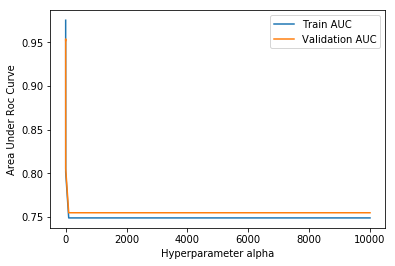

In [63]:

# Alpha v/s AUC SCORE

X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_lbow, Y_ltrain, test_size=0.3)

alpha=[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4]

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for alph in alpha:
    clf=SGDClassifier(alpha=alph, loss='hinge', penalty='l2')
    calibrated_clf=CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    
    clf1=calibrated_clf.fit(X_tr,Y_tr)
    pred_train = clf1.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=clf1.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(alpha,auc_train )
plt.plot(alpha,auc_val)
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    


AUC: 0.955


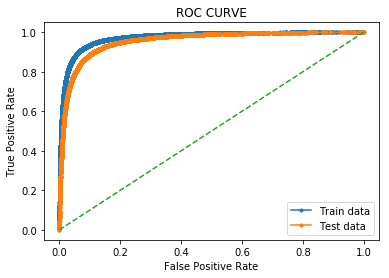

In [65]:
clf = SGDClassifier(alpha=0.0001,loss='hinge',penalty='l2')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
calibrated_clf.fit(Xtrain_lbow,Y_ltrain)

# predict probabilities
probs = calibrated_clf.predict_proba(Xtest_lbow)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_ltest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=calibrated_clf.predict_proba(Xtrain_lbow)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_ltrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_ltest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()



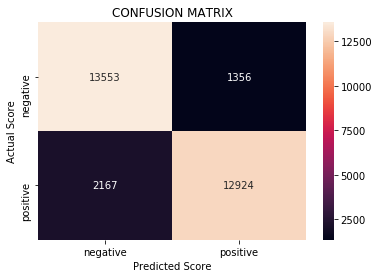

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

clf=SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
clf.fit(Xtrain_lbow,Y_ltrain)

pred = clf.predict(Xtest_lbow)
con_mat=confusion_matrix(Y_ltest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [67]:
#GRID-SEARCH CV
tuned_parameters= [{'alpha':[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4] ,'penalty': ['l1','l2']}]

clf = SGDClassifier(loss='hinge')


model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_ltf, Y_ltrain)

print(model.best_estimator_)
print(model.score(Xtest_ltf, Y_ltest))


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.959536117415948


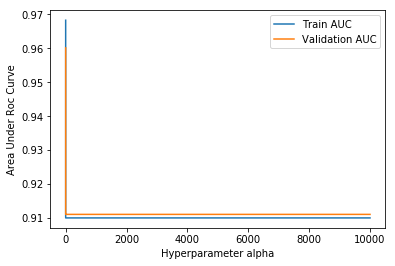

In [68]:
# Alpha v/s AUC SCORE
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_ltf, Y_ltrain, test_size=0.3)

alpha=[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4]

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for alph in alpha:
    clf=SGDClassifier(alpha=alph, loss='hinge', penalty='l2')
    calibrated_clf=CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    
    clf1=calibrated_clf.fit(X_tr,Y_tr)
    pred_train = clf1.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=clf1.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(alpha,auc_train )
plt.plot(alpha,auc_val)
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    


AUC: 0.960


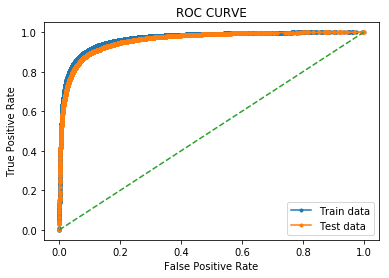

In [69]:
#ROC CURVE FOR TRAIN AND TEST DATA
clf = SGDClassifier(alpha=0.0001,loss='hinge',penalty='l2')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
calibrated_clf.fit(Xtrain_ltf,Y_ltrain)

# predict probabilities
probs = calibrated_clf.predict_proba(Xtest_ltf)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_ltest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=calibrated_clf.predict_proba(Xtrain_ltf)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_ltrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_ltest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()



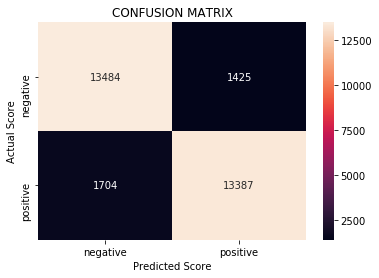

In [70]:
#CONFUSION MATRIX

clf=SGDClassifier(alpha=0.0001, loss='hinge', penalty='l2')
clf.fit(Xtrain_ltf,Y_ltrain)

pred = clf.predict(Xtest_ltf)
con_mat=confusion_matrix(Y_ltest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [71]:
#GRID-SEARCH CV
tuned_parameters= [{'alpha':[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4] ,'penalty': ['l1','l2']}]

clf = SGDClassifier(loss='hinge')


model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(lin_train, Y_ltrain)

print(model.best_estimator_)
print(model.score(lin_test, Y_ltest))


SGDClassifier(alpha=0.001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.9171129116089823


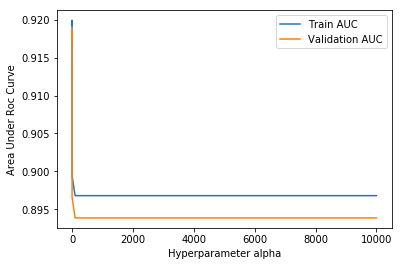

In [72]:
# Alpha v/s AUC SCORE
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(lin_train, Y_ltrain, test_size=0.3)

alpha=[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4]

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for alph in alpha:
    clf=SGDClassifier(alpha=alph, loss='hinge', penalty='l2')
    calibrated_clf=CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    
    clf1=calibrated_clf.fit(X_tr,Y_tr)
    pred_train = clf1.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=clf1.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(alpha,auc_train )
plt.plot(alpha,auc_val)
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    


AUC: 0.918


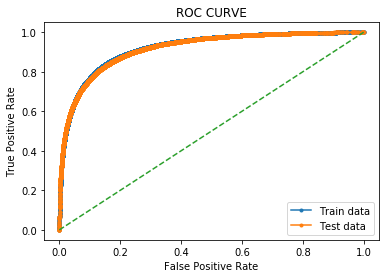

In [73]:
#ROC CURVE FOR TRAIN AND TEST DATA
clf = SGDClassifier(alpha=0.001,loss='hinge',penalty='l2')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
calibrated_clf.fit(lin_train,Y_ltrain)

# predict probabilities
probs = calibrated_clf.predict_proba(lin_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_ltest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=calibrated_clf.predict_proba(lin_train)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_ltrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_ltest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()



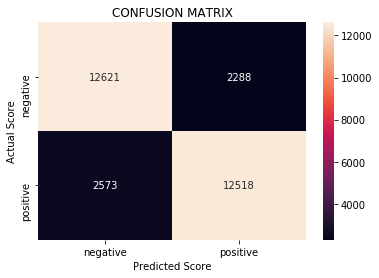

In [74]:
#CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix

clf=SGDClassifier(alpha=0.001, loss='hinge', penalty='l2')
clf.fit(lin_train,Y_ltrain)

pred = clf.predict(lin_test)
con_mat=confusion_matrix(Y_ltest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [75]:
#GRID-SEARCH CV
tuned_parameters= [{'alpha':[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4] ,'penalty': ['l1','l2']}]

clf = SGDClassifier(loss='hinge')


model = GridSearchCV(clf, tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(ltraintf, Y_ltrain)

print(model.best_estimator_)
print(model.score(ltesttf, Y_ltest))


SGDClassifier(alpha=0.01, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)
0.892034944183879


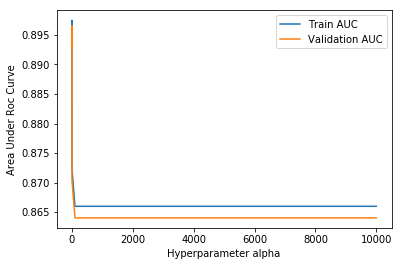

In [76]:
# Alpha v/s AUC SCORE
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(ltraintf, Y_ltrain, test_size=0.3)

alpha=[10**-4,10**-3, 10**-2, 10**0, 10**2,10**3, 10**4]

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for alph in alpha:
    clf=SGDClassifier(alpha=alph, loss='hinge', penalty='l2')
    calibrated_clf=CalibratedClassifierCV(clf, cv=5, method='sigmoid')
    
    clf1=calibrated_clf.fit(X_tr,Y_tr)
    pred_train = clf1.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=clf1.predict_proba(X_cv)[0:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(alpha,auc_train )
plt.plot(alpha,auc_val)
plt.xlabel('Hyperparameter Alpha')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    


AUC: 0.892


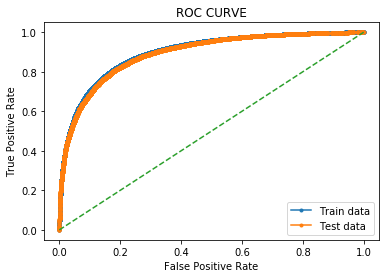

In [77]:
#ROC CURVE FOR TRAIN AND TEST DATA
clf = SGDClassifier(alpha=0.01,loss='hinge',penalty='l2')
calibrated_clf = CalibratedClassifierCV(clf, cv=5, method='sigmoid')
calibrated_clf.fit(ltraintf,Y_ltrain)

# predict probabilities
probs = calibrated_clf.predict_proba(ltesttf)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_ltest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=calibrated_clf.predict_proba(ltraintf)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_ltrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_ltest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()



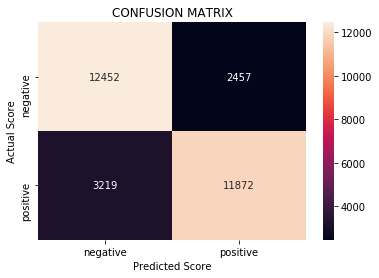

In [78]:
#CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix

clf=SGDClassifier(alpha=0.01, loss='hinge', penalty='l2')
clf.fit(ltraintf,Y_ltrain)

pred = clf.predict(ltesttf)
con_mat=confusion_matrix(Y_ltest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [39]:
#GRIDSEARCHCV
from sklearn.model_selection import GridSearchCV
tuned_parameters= [{'C': np.logspace(-5,5,11,base=2),'gamma': np.logspace(-5,5,11,base=2)}]

model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_rbow, Y_rtrain)

print(model.best_estimator_)
print(model.score(Xtest_rbow, Y_rtest))

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.03125, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9019129473185002


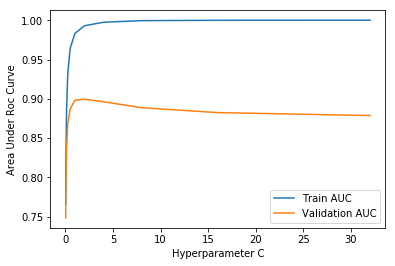

In [43]:
# C v/s AUC SCORE
from sklearn import cross_validation
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_rbow, Y_rtrain, test_size=0.3)

c=np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in c:
    model = svm.SVC(C=item,gamma=0.03125,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    

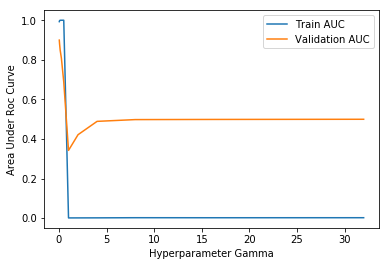

In [44]:
# Gamma v/s AUC SCORE
gam= np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in gam:
    model = svm.SVC(C=2,gamma=item,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter Gamma')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    

AUC: 0.902


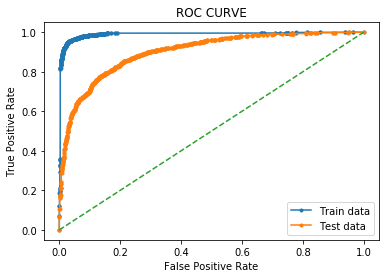

In [45]:
#ROC CURVE FOR TRAIN AND TEST DATA
model = svm.SVC(C=2,gamma=.03125,probability=True)
model.fit(Xtrain_rbow,Y_rtrain)

# predict probabilities
probs = model.predict_proba(Xtest_rbow)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_rtest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=model.predict_proba(Xtrain_rbow)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_rtrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_rtest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()


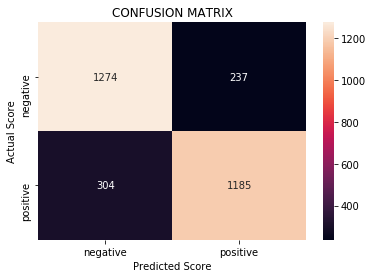

In [46]:
#CONFUSION MATRIX
model = svm.SVC(C=2,gamma=.03125,probability=True)
model.fit(Xtrain_rbow,Y_rtrain)


pred = model.predict(Xtest_rbow)
con_mat=confusion_matrix(Y_rtest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

### [5.2.2] Applying RBF SVM on TFIDF,<font color='red'> SET 2</font>

In [47]:
#GRIDSEARCHCV
tuned_parameters= [{'C': np.logspace(-5,5,11,base=2),'gamma': np.logspace(-5,5,11,base=2)}]

model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(Xtrain_rtf, Y_rtrain)

print(model.best_estimator_)
print(model.score(Xtest_rtf, Y_rtest))

SVC(C=2.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.9150078737567665


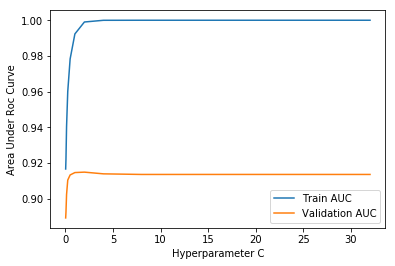

In [50]:
# C v/s AUC SCORE
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(Xtrain_rtf, Y_rtrain, test_size=0.3)

c=np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in c:
    model = svm.SVC(C=item,gamma=1,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    

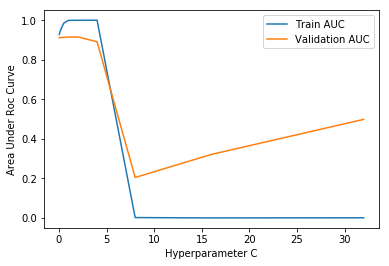

In [51]:
# Gamma v/s AUC SCORE
gam= np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in gam:
    model = svm.SVC(C=2,gamma=item,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    

AUC: 0.915


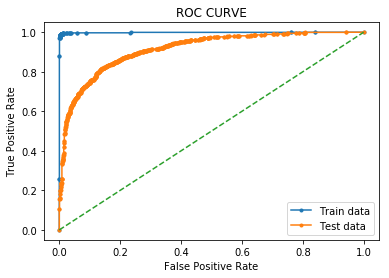

In [52]:
#ROC CURVE FOR TRAIN AND TEST DATA
model = svm.SVC(C=2,gamma=1,probability=True)
model.fit(Xtrain_rtf,Y_rtrain)

# predict probabilities
probs = model.predict_proba(Xtest_rtf)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_rtest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=model.predict_proba(Xtrain_rtf)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_rtrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_rtest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()

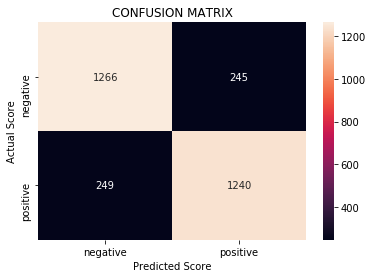

In [54]:
#CONFUSION MATRIX
model = svm.SVC(C=2,gamma=1,probability=True)
model.fit(Xtrain_rtf,Y_rtrain)


pred = model.predict(Xtest_rtf)
con_mat=confusion_matrix(Y_rtest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

### [5.2.3]  Applying RBF SVM on AVG W2V,<font color='red'> SET 3</font>

In [48]:
#HYPERPARAMETER TUNING USING GRIDSEARCH
tuned_parameters= [{'C': np.logspace(-5,5,11,base=2),'gamma': np.logspace(-5,5,11,base=2)}]

model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(rbf_train, Y_rtrain)

print(model.best_estimator_)
print(model.score(rbf_test, Y_rtest))

SVC(C=32.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8542468283849932


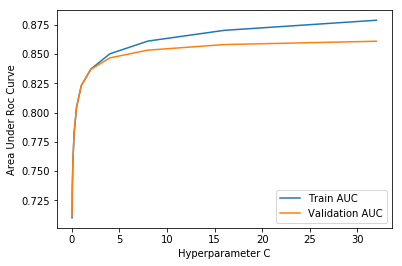

In [55]:
# C v/s AUC SCORE
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(rbf_train, Y_rtrain, test_size=0.3)

c=np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in c:
    model = svm.SVC(C=item,gamma=0.5,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()

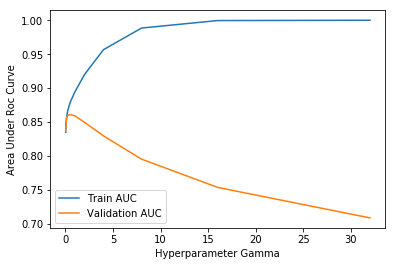

In [56]:
# Gamma v/s AUC SCORE
gam= np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in gam:
    model = svm.SVC(C=32,gamma=item,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter Gamma')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    

AUC: 0.854


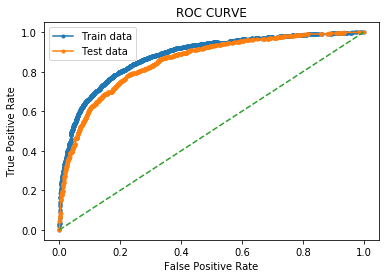

In [57]:
#ROC CURVE FOR TRAIN AND TEST DATA
model = svm.SVC(C=32,gamma=0.5,probability=True)
model.fit(rbf_train,Y_rtrain)

# predict probabilities
probs = model.predict_proba(rbf_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_rtest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=model.predict_proba(rbf_train)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_rtrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_rtest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()

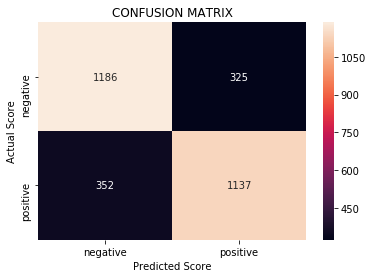

In [58]:
#CONFUSION MATRIX
model = svm.SVC(C=32,gamma=0.5,probability=True)
model.fit(rbf_train,Y_rtrain)


pred = model.predict(rbf_test)
con_mat=confusion_matrix(Y_rtest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

### [5.2.4]  Applying RBF SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [49]:
#HYPERPARAMETER TUNING USING GRIDSEARCH
tuned_parameters= [{'C': np.logspace(-5,5,11,base=2),'gamma': np.logspace(-5,5,11,base=2)}]

model = GridSearchCV(svm.SVC(), tuned_parameters, scoring = 'roc_auc', cv=5)
model.fit(rtraintf, Y_rtrain)

print(model.best_estimator_)
print(model.score(rtesttf, Y_rtest))

SVC(C=32.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.8330167977922368


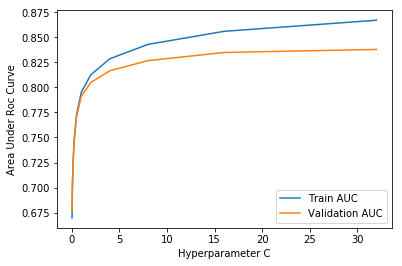

In [59]:
# C v/s AUC SCORE
X_tr, X_cv, Y_tr, Y_cv = cross_validation.train_test_split(rtraintf, Y_rtrain, test_size=0.3)

c=np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in c:
    model = svm.SVC(C=item,gamma=0.5,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter C')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()

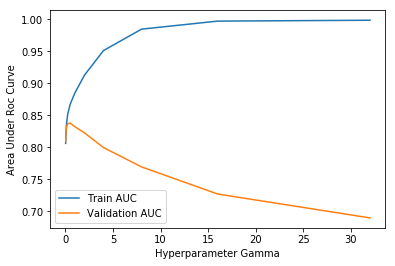

In [60]:
# Gamma v/s AUC SCORE
gam= np.logspace(-5,5,11,base=2)

# empty list that will hold cv scores
auc_train=[]
auc_val=[]

# perform 10-fold cross validation
for item in gam:
    model = svm.SVC(C=32,gamma=item,probability=True)
    model.fit(X_tr,Y_tr)
    pred_train=model.predict_proba(X_tr)[:,1]
    auc_train.append(roc_auc_score(Y_tr, pred_train))
    
    pred_val=model.predict_proba(X_cv)[:,1]
    auc_val.append(roc_auc_score(Y_cv,pred_val))

    
# plot 
plt.plot(c,auc_train )
plt.plot(c,auc_val)
plt.xlabel('Hyperparameter Gamma')
plt.ylabel('Area Under Roc Curve')
plt.legend(['Train AUC','Validation AUC'])
plt.show()
    

AUC: 0.833


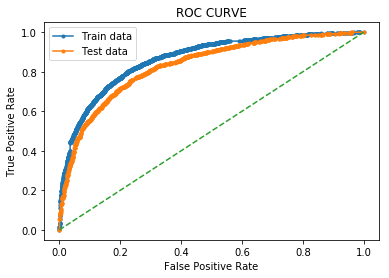

In [61]:
#ROC CURVE FOR TRAIN AND TEST DATA
model = svm.SVC(C=32,gamma=0.5,probability=True)
model.fit(rtraintf,Y_rtrain)

# predict probabilities
probs = model.predict_proba(rtesttf)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(Y_rtest, probs)
print('AUC: %.3f' % auc)

# calculate roc curve for train data
prob=model.predict_proba(rtraintf)
probt=prob[:,1]
tfpr, ttpr, thresholds = roc_curve(Y_rtrain, probt)



#calculate roc curve for test data
fpr,tpr,threshols=roc_curve(Y_rtest,probs)




# plot the roc curve for the model
plt.plot(tfpr, ttpr, marker='.')
plt.plot(fpr,tpr,marker='.')

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(["Train data","Test data"])
# show the plot
plt.show()

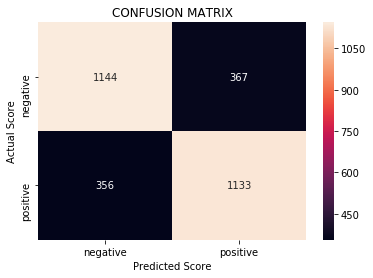

In [62]:
#CONFUSION MATRIX
model = svm.SVC(C=32,gamma=0.5,probability=True)
model.fit(rtraintf,Y_rtrain)


pred = model.predict(rtesttf)
con_mat=confusion_matrix(Y_rtest,pred)
cmt=pd.DataFrame(con_mat,index=['negative','positive'],columns=['negative','positive'])

#plotting confusion matrix
sns.heatmap(cmt,annot=True, fmt="d")
plt.title("CONFUSION MATRIX")
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

# [6] Conclusions

In [63]:
#CREATING PRETTYTABLE
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Kernel","Alpha","C","Gamma", "AUC"]
 
x.add_row(["BOW","linear",0.0001,"Nil","Nil",0.955])
x.add_row(["TFIDF","linear",0.0001,"Nil","Nil",0.960])
x.add_row(["WORD2VEC","linear",0.001,"Nil","Nil",0.918])
x.add_row(["TFIDF-W2V","linear",0.01,"Nil","Nil",0.892])
x.add_row(["BOW","rbf","Nil",2,0.03125,0.902])
x.add_row(["TFIDF","rbf","Nil",2,1,0.915])
x.add_row(["WORD2VEC","rbf","Nil",32,0.5,0.854])
x.add_row(["TFIDF_W2V","rbf","Nil",32,0.5,0.833])

print(x)

+------------+--------+--------+-----+---------+-------+
| Vectorizer | Kernel | Alpha  |  C  |  Gamma  |  AUC  |
+------------+--------+--------+-----+---------+-------+
|    BOW     | linear | 0.0001 | Nil |   Nil   | 0.955 |
|   TFIDF    | linear | 0.0001 | Nil |   Nil   |  0.96 |
|  WORD2VEC  | linear | 0.001  | Nil |   Nil   | 0.918 |
| TFIDF-W2V  | linear |  0.01  | Nil |   Nil   | 0.892 |
|    BOW     |  rbf   |  Nil   |  2  | 0.03125 | 0.902 |
|   TFIDF    |  rbf   |  Nil   |  2  |    1    | 0.915 |
|  WORD2VEC  |  rbf   |  Nil   |  32 |   0.5   | 0.854 |
| TFIDF_W2V  |  rbf   |  Nil   |  32 |   0.5   | 0.833 |
+------------+--------+--------+-----+---------+-------+
